# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice I'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

In [56]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models

import json

from PIL import Image

from collections import OrderedDict


## Load the data

Now I'll use `torchvision` to load the data. The dataset is split into three parts, training, validation, and testing. For the training, I'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations but I'll need to resize then crop the images to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [57]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [58]:
#Defining your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

#Loading the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)


#Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32)

### Label mapping

I'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [59]:


with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, I should use one of the pretrained models from `torchvision.models` to get the image features. I wil build and train a new feed-forward classifier using those features.

I'll need to do the following:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [60]:
#using GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
#Loading a pre-trained network
model = models.vgg19(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [62]:
#Freezing parameters
for param in model.parameters():
    param.requires_grad = False
    
#Defining a new, untrainted feed-forward network as a classifier using ReLU activations and dropout


classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088,512)),
                          ('relu1', nn.ReLU()),
                          ('dropout',nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

#Defining optimizer and loss
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [15]:
#Training the classifier layers using backpropagation using the pre-trained network to get the features

epochs = 5
steps = 0
running_loss = 0
print_every = 30

for epoch in range(epochs):
    
    for inputs, labels in trainloader:
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        #forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model.forward(inputs)
                    valid_loss = criterion(outputs, labels)
                    
                    # Calculate accuracy
                    ps = torch.exp(outputs)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Accuracy: {accuracy/len(validloader):.3f}")
            
            running_loss = 0
            model.train()

Epoch 1/5.. Train loss: 4.201.. Validation loss: 0.143.. Accuracy: 0.413
Epoch 1/5.. Train loss: 3.177.. Validation loss: 0.098.. Accuracy: 0.529
Epoch 1/5.. Train loss: 2.592.. Validation loss: 0.071.. Accuracy: 0.628
Epoch 2/5.. Train loss: 2.214.. Validation loss: 0.040.. Accuracy: 0.707
Epoch 2/5.. Train loss: 2.007.. Validation loss: 0.057.. Accuracy: 0.743
Epoch 2/5.. Train loss: 1.819.. Validation loss: 0.046.. Accuracy: 0.759
Epoch 3/5.. Train loss: 1.854.. Validation loss: 0.035.. Accuracy: 0.773
Epoch 3/5.. Train loss: 1.707.. Validation loss: 0.027.. Accuracy: 0.808
Epoch 3/5.. Train loss: 1.563.. Validation loss: 0.029.. Accuracy: 0.800
Epoch 3/5.. Train loss: 1.557.. Validation loss: 0.043.. Accuracy: 0.805
Epoch 4/5.. Train loss: 1.492.. Validation loss: 0.028.. Accuracy: 0.814
Epoch 4/5.. Train loss: 1.608.. Validation loss: 0.018.. Accuracy: 0.829
Epoch 4/5.. Train loss: 1.478.. Validation loss: 0.037.. Accuracy: 0.827
Epoch 5/5.. Train loss: 1.451.. Validation loss: 0.

## Testing your network

It's good practice to test my trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. I will run the test images through the network and measure the accuracy, the same way I did validation.

In [16]:
total = 0
correct = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"The accuracy of the model on the test set is:{round(correct / total * 100,2)}%.")

The accuracy of the model on the test set is:67.52%.


## Save the checkpoint

Now that the network is trained, I will save the model so I can load it later for making predictions. I will also save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`

```model.class_to_idx = image_datasets['train'].class_to_idx```

I'll want to completely rebuild the model later so I can use it for inference. I will include all information I need in the checkpoint. In order to load the model and keep training, I will need to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. I'll likely want to use this trained model in the next part of the project, so now I will save it.

In [66]:
#Saving the checkpoint

checkpoint = {'classifier': model.classifier,
              'class_to_idx': train_data.class_to_idx,
              'state_dict': model.state_dict(),
              'num_epochs': epochs,
              'opt_state': optimizer.state_dict}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [63]:
#writing a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    # Checkpoint for when using GPU
    checkpoint = torch.load(filepath)
    model = models.vgg19()
    
    model.classifier = checkpoint['classifier'] 
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

# Inference for classification

Now I'll write a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. I will write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First I'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

I'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, I will resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I'll need to convert the values. It's easiest with a Numpy array, which I can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [64]:
def process_image(image_path):

    size = 256, 256
    crop_size = 224
    
    img = Image.open(image_path)
    
    img.thumbnail(size)

    left = (size[0] - crop_size)/2
    top = (size[1] - crop_size)/2
    right = (left + crop_size)
    bottom = (top + crop_size)

    img = img.crop((left, top, right, bottom))
    
    np_image = np.array(img)
    np_image = np_image/255
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    
    np_image = (np_image - means) / stds
    
    pyt_np_image = np_image.transpose(2,0,1)
    
    return pyt_np_image

To check my work, the function below converts a PyTorch tensor and displays it in the notebook. If my `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [65]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    #Undoing preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    #Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [66]:
#Testing image
image_name = data_dir + '/test' + '/1/' + 'image_06754'
image_test = process_image(image_name)

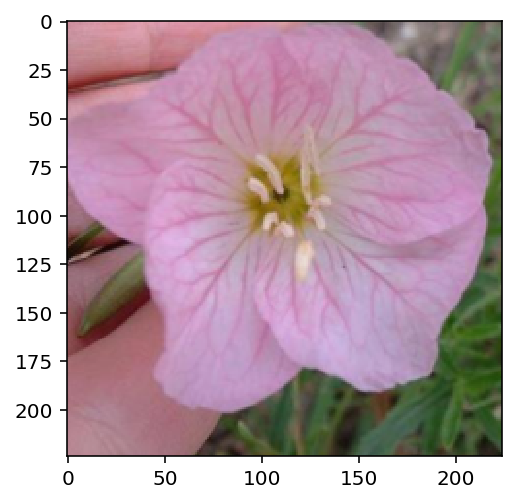

In [67]:
#Checking if image pre-processing was successful
imshow(image_test, ax=None, title=None)

## Class Prediction

Once I can get images in the correct format, it's time to write a function for making predictions with my model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor I will use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I need to convert from these indices to the actual class labels using `class_to_idx`. I will invert the dictionary so I can get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [68]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    #Implementing the code to predict the class from an image file   
    
    #Loading model
    loaded_model = load_checkpoint(model).cpu()
    #Pre-processing image
    image = process_image(image_path)
    #Converting to torch tensor from Numpy array
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    
    image_unsqueezed = image_tensor.unsqueeze_(0)

    
    loaded_model.eval()
    with torch.no_grad():
        output = loaded_model.forward(image_unsqueezed)

    #Calculating probabilities
    probs = torch.exp(output)
    probs_top, index_top = probs.topk(topk)
    
    probs_top_list = np.array(probs_top)[0]
    index_top_list = np.array(index_top[0])
    
    class_to_idx = loaded_model.class_to_idx
    indx_to_class = {x: y for y, x in class_to_idx.items()}
    classes_top_list = []
    
    for index in index_top_list:
        classes_top_list += [indx_to_class[index]]
        
    return probs_top_list, classes_top_list

In [69]:
model_path = 'checkpoint.pth' 
image_path = data_dir + '/test' + '/1/' + 'image_06754'

probs,classes = predict(image_path, model_path, topk=5)

print(probs)
print(classes)

[ 0.22435687  0.18150948  0.17578292  0.11513285  0.09872241]
['97', '95', '1', '98', '76']


## Sanity Checking

Now that I can use a trained model for predictions, I will check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

I can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file. To show a PyTorch tensor as an image, I will use the `imshow` function defined above.

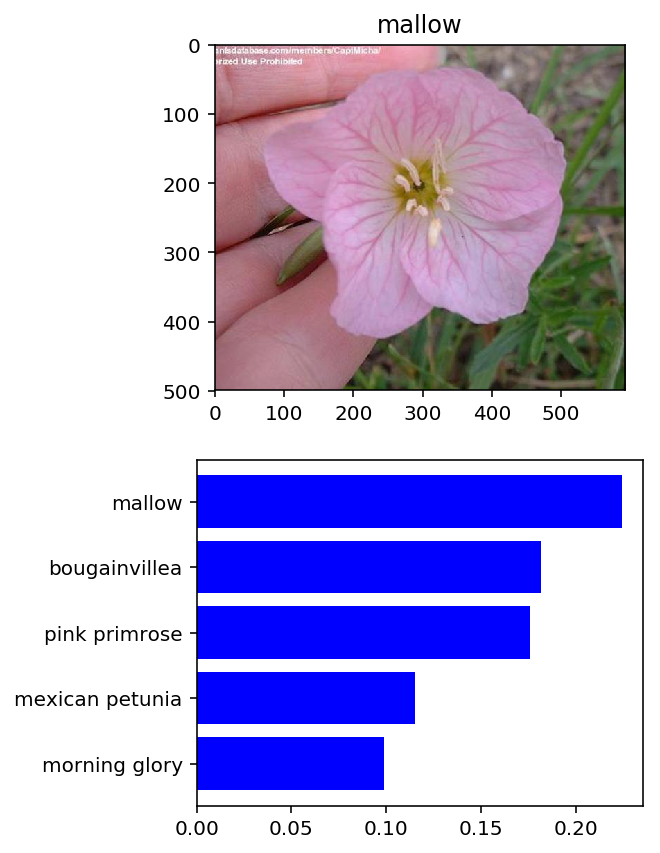

In [72]:
#Displaying an image along with the top 5 classes

model_path = 'checkpoint.pth'
image_path = data_dir + '/test' + '/1/' + 'image_06754'

probs,classes = predict(image_path, model_path, topk=5)

#Converting classes to names
names = []
for i in classes:
    names += [cat_to_name[i]]

image = Image.open(image_path+'.jpg')

f, ax = plt.subplots(2,figsize = (4,7))

ax[0].imshow(image)
ax[0].set_title(names[0])

y_names = np.arange(len(names))

ax[1].set_yticklabels(names)
ax[1].set_yticks(y_names)

ax[1].invert_yaxis() 
ax[1].barh(y_names, probs, color='blue')

plt.show()